In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline

## Creating Data

Let's look at a cloud of data points surrounded by a circle. For this example, for each entry in the inner cloud is drawn from a $N(0,0.01)$, and each entry of the outer circle is sampled from a unit circle, with $N(0,0.01)$ noise added to each coordinate.

In [2]:
sampling_size = 100

sample = np.arange(sampling_size) * (np.pi/50)
outer_cloud = np.concatenate((np.expand_dims(np.cos(sample),1), np.expand_dims(np.sin(sample),1)), axis=1) + 0.1 * np.random.randn(sampling_size, 2)

inner_cloud = 0.1 * np.random.randn(sampling_size,2)

data = np.concatenate((outer_cloud, inner_cloud), axis=0)
colormap = np.concatenate((np.zeros(sampling_size),np.ones(sampling_size)))

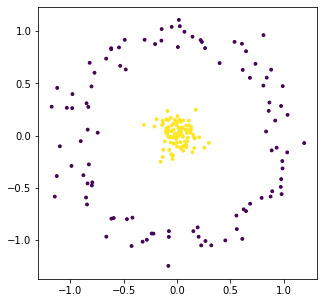

In [3]:
plt.figure(figsize=(5,5))
plt.scatter(data.T[0], data.T[1], s=8, c=colormap)


### Some embeddings of this data

In [4]:
emb = np.empty((5, 2*sampling_size, 2))

In [5]:
emb[0] = KernelPCA(n_components=2, kernel='linear').fit_transform(data)
emb[1] = KernelPCA(n_components=2, kernel='poly').fit_transform(data)
emb[2] = KernelPCA(n_components=2, kernel='rbf').fit_transform(data)
emb[3] = KernelPCA(n_components=2, kernel='sigmoid').fit_transform(data)
emb[4] = KernelPCA(n_components=2, kernel='cosine').fit_transform(data)

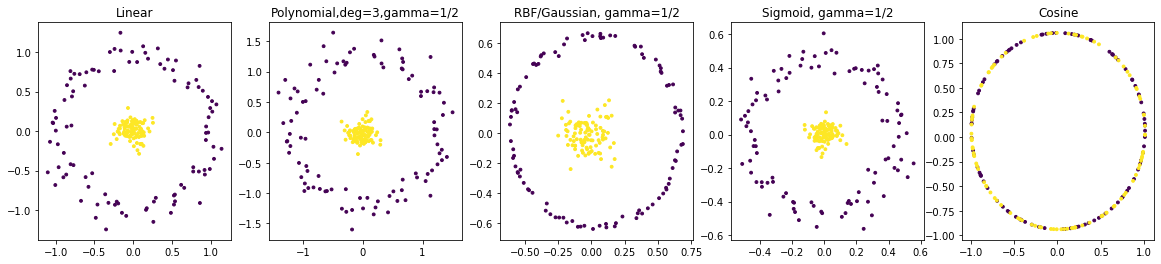

In [6]:
desc = ['Linear','Polynomial,deg=3,gamma=1/2', 'RBF/Gaussian, gamma=1/2', 'Sigmoid, gamma=1/2', 'Cosine']

fig,axes = plt.subplots(1,5, figsize=(20,4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i].T[0], emb[i].T[1], s=8, c=colormap)
    ax.set_title(desc[i])


### Varying Gamma for RBF (Gaussian) Kernel

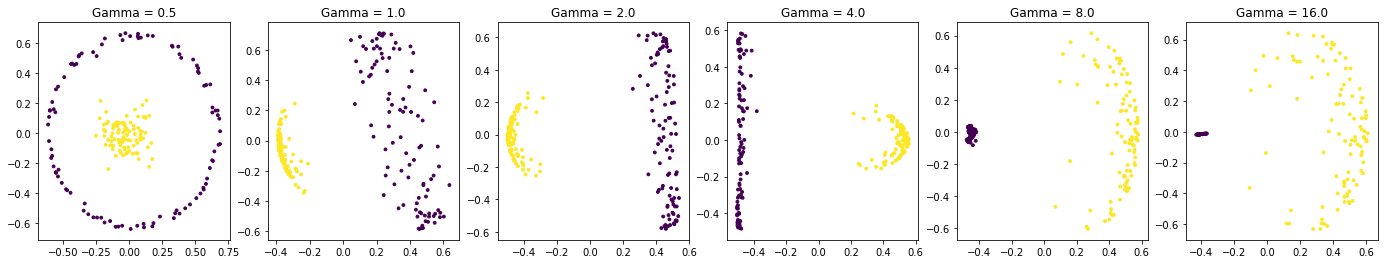

In [7]:
gamma_vals = np.asarray([0.5, 1, 2, 4, 8, 16])

emb = np.empty((gamma_vals.shape[0], 2*sampling_size, 2))

for i in range(gamma_vals.shape[0]):
    emb[i] = KernelPCA(n_components=2, kernel='rbf', gamma=gamma_vals[i]).fit_transform(data)

fig,axes = plt.subplots(1,gamma_vals.shape[0], figsize=(4*gamma_vals.shape[0],4))
for i,ax in enumerate(axes.flat):
    ax.scatter(emb[i].T[0], emb[i].T[1], s=8, c=colormap)
    ax.set_title(f"Gamma = {gamma_vals[i]}")


# Randomized KPCA

We can add randomness into Kernel PCA in two main ways:

- Using randomness to lower the dimensionality of the data matrix, similarly to RSVD
- Using randomness in the kernel function

First we attempt the second

In [8]:
def RKPCA(data, n_components, m):
    X = np.copy(data)       # n x d
    n = X.shape[0] # number of data pts
    d = X.shape[1] # dimensionality of data
    b = np.random.uniform(low=0, high = 2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=m) # m x d
    Z = np.empty((n,m))
    Z = np.cos(X @ W.T + b) # n x m
    K = 1/m * Z @ Z.T
    return KernelPCA(n_components=n_components, kernel='precomputed').fit_transform(K)

In [9]:
#%matplotlib inline
X = data       # n x d

n = X.shape[0] # number of data pts
d = X.shape[1] # dimensionality of data

m = 10          # low dimension m << n
b = np.zeros((1,m))#np.random.uniform(low=0, high = 2*np.pi, size=(1,m))


In [10]:
start = perf_counter()
W = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=m) # m x d
Z = np.empty((n,m))
Z = np.cos(X @ W.T + b) # n x m
K = 1/m * Z @ Z.T

Text(0.5, 1.0, 'Random KPCA')

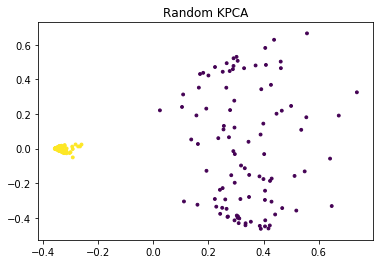

In [11]:
emb = KernelPCA(n_components=2, kernel='precomputed').fit_transform(K)
end = perf_counter()
t2 = end-start
#start = perf_counter()
#_ = KernelPCA(n_components=2, kernel='rbf', gamma=2).fit_transform(data)
#end = perf_counter()
t1 = end-start
plt.scatter(emb.T[0],emb.T[1], s=8, c=colormap)
plt.title('Random KPCA')

In [12]:
def plot(embedding, color_labels):
    if(embedding.shape[1] == 2):
        %matplotlib inline
        plt.scatter(embedding.T[0],embedding.T[1],s=8,c=color_labels)
        plt.show()
    elif(embedding.shape[1]==3):
        %matplotlib notebook
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(embedding.T[0],embedding.T[1],embedding.T[2], s=8, c=color_labels)
        plt.show()
    else:
        raise ValueError

In [13]:
print(t1,t2)

0.03541019999999939 0.03541019999999939


In [14]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

X = mnist[mnist.columns[1:]].values / 255
y = mnist.label.values

X = X[:1000]
y = y[:1000]

print(X.shape)


(1000, 784)


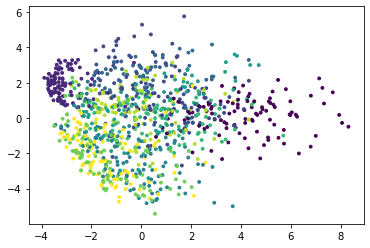

In [15]:
%matplotlib inline
emb = KernelPCA(n_components=2, kernel='linear').fit_transform(X)
plt.scatter(emb.T[0],emb.T[1],s=8,c=y)

In [16]:
%matplotlib notebook

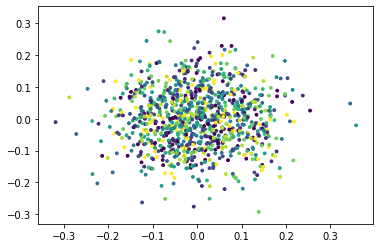

In [17]:
emb = RKPCA(X, 2, 100)
plot(emb, y)

In [18]:
#Reference
#from sklearn import manifold
#plot(manifold.TSNE(n_components=2).fit_transform(X), y)

In [19]:
#plot(manifold.TSNE(n_components=3).fit_transform(X), y)

In [20]:
# #Classification:

# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# classifier = SVC()
# classifier.fit(RKPCA(X_train, 10), y_train)
# classifier.score(RKPCA(X_test, 10), y_test)

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


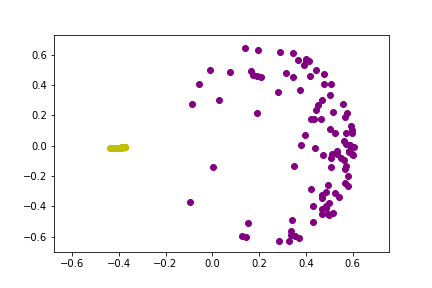

interactive(children=(FloatSlider(value=0.5, description='gamma', max=30.0, step=0.25), Output()), _dom_classe…

<function __main__.update(gamma)>

In [22]:
# TEST cell for plotting
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

plt.ion()

emb = KernelPCA(n_components=2, kernel='rbf', gamma=0.5).fit_transform(data)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
outer, = ax.plot(emb.T[0][:100],emb.T[1][:100],marker='o', linestyle='', color='y')
inner, = ax.plot(emb.T[0][100:200],emb.T[1][100:200],marker='o', linestyle='', color='purple')

def update(gamma):
    emb = KernelPCA(n_components=2, kernel='rbf', gamma=gamma).fit_transform(data)
    outer.set_xdata(emb.T[0][:100])
    outer.set_ydata(emb.T[1][:100])
    inner.set_xdata(emb.T[0][100:200])
    inner.set_ydata(emb.T[1][100:200])
    
    fig.canvas.draw_idle()

interact(update, gamma = widgets.FloatSlider(value=0.5,min=0,max=30,step=0.25))